# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [370]:
# Load the libraries as required.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import shap
import matplotlib.pyplot as plt

In [371]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [372]:
#feature dataframe
X = fires_dt.drop(columns = 'area')
# target dataframe
Y = fires_dt['area']

In [373]:
# I prefered to split dataset into train and test based on time to ensure that 
# the model is capable of predicting future based on the data from the past. 
# However, there is no feature that I can order the samples in chronological order. 
# So, I split it based on rndom sampling 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.columns

Index(['coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi',
       'temp', 'rh', 'wind', 'rain'],
      dtype='object')

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [374]:
categorical_features = ['month', 'day']
numerical_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi','temp', 'rh', 'wind', 'rain']

preproc1 = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_features),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [375]:
import pandas as pd
import numpy as np
from scipy.stats import skew

# Calculate skewness for each numerical feature
skewness_values = X_train[numerical_features].apply(skew)

# Identify features with high skewness (threshold = ±0.5)
skewed_features = skewness_values[abs(skewness_values) > 0.5].index.tolist()

# Print the results
print("Skewness of numerical features:")
print(skewness_values)

print("\nFeatures with higher skewness:")
print(skewed_features)


Skewness of numerical features:
coord_x     0.067494
coord_y     0.486099
ffmc       -6.450340
dmc         0.580012
dc         -1.093043
isi         0.585618
temp       -0.271321
rh          0.847016
wind        0.564970
rain       19.043078
dtype: float64

Features with higher skewness:
['ffmc', 'dmc', 'dc', 'isi', 'rh', 'wind', 'rain']


In [376]:
categorical_features = ['month', 'day']
normal_num = ['coord_x', 'coord_y', 'temp']
skewed_num = ['ffmc', 'dmc', 'dc', 'isi', 'rh', 'wind', 'rain']

preproc2 = ColumnTransformer([
    ('num_scaled', MinMaxScaler(), normal_num),  
    ('num_transformed', PowerTransformer(), skewed_num),  
    ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features) 
])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [377]:
# Pipeline A = preproc1 + baseline
pipe_A = Pipeline([
    ('preprocess', preproc1),
    ('model', Ridge())
])
pipe_A

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('model', Ridge())])

In [378]:
# Pipeline B = preproc2 + baseline
pipe_B = Pipeline([
    ('preprocess', preproc2),
    ('model', Ridge())
])
pipe_B

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_scaled', MinMaxScaler(),
                                                  ['coord_x', 'coord_y',
                                                   'temp']),
                                                 ('num_transformed',
                                                  PowerTransformer(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('model', Ridge())])

In [379]:
# Pipeline C = preproc1 + advanced model
pipe_C = Pipeline([
    ('preprocess', preproc1),
    ('model', RandomForestRegressor())
])
pipe_C

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('model', RandomForestRegressor())])

In [380]:
# Pipeline D = preproc2 + advanced model
pipe_D = Pipeline([
    ('preprocess', preproc2),
    ('model', RandomForestRegressor())
])
pipe_D
    

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_scaled', MinMaxScaler(),
                                                  ['coord_x', 'coord_y',
                                                   'temp']),
                                                 ('num_transformed',
                                                  PowerTransformer(),
                                                  ['ffmc', 'dmc', 'dc', 'isi',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('model', RandomForestRegressor())])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [381]:
scoring = 'neg_mean_squared_error'

param_grid_A = {'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0], 
                'model__fit_intercept': [True, False]}
param_grid_B = {'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0], 
                'model__fit_intercept': [True, False]}
param_grid_C = {'model__n_estimators': [10, 50, 100], 'model__max_depth': [2, 3, 4]}
param_grid_D = {'model__n_estimators': [10, 50, 100], 'model__max_depth': [2, 3, 4]}

# Run GridSearchCV
grid_A = GridSearchCV(pipe_A, param_grid_A, scoring = scoring, cv = 5, refit = True)
grid_B = GridSearchCV(pipe_B, param_grid_B, scoring = scoring, cv = 5, refit = True)
grid_C = GridSearchCV(pipe_C, param_grid_C, scoring = scoring, cv = 5, refit = True)
grid_D = GridSearchCV(pipe_D, param_grid_D, scoring = scoring, cv = 5, refit = True)

In [382]:
grid_A.fit(X_train, Y_train)
grid_B.fit(X_train, Y_train)
grid_C.fit(X_train, Y_train)
grid_D.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num_scaled',
                                                                         MinMaxScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'temp']),
                                                                        ('num_transformed',
                                                                         PowerTransformer(),
                                                                         ['ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('model', RandomForestRegressor())]),
             param_grid={'model__max_depth': [2, 3, 4],
                         'model__n_estimators': [10, 50, 100]},
             scoring='neg_mean_squared_error')

In [383]:
# Print best hyperparameters
print("Best params for Pipeline A:", grid_A.best_params_)
print("Best params for Pipeline B:", grid_B.best_params_)
print("Best params for Pipeline C:", grid_C.best_params_)
print("Best params for Pipeline D:", grid_D.best_params_)

Best params for Pipeline A: {'model__alpha': 100.0, 'model__fit_intercept': True}
Best params for Pipeline B: {'model__alpha': 100.0, 'model__fit_intercept': False}
Best params for Pipeline C: {'model__max_depth': 2, 'model__n_estimators': 10}
Best params for Pipeline D: {'model__max_depth': 3, 'model__n_estimators': 50}


In [384]:
eval_metric = mean_squared_error

# Evaluate for pipline A
best_model_A = grid_A.best_estimator_
y_pred_A = best_model_A.predict(X_test)
mse_A = eval_metric(Y_test, y_pred_A)

# Evaluate for pipline B
best_model_B = grid_B.best_estimator_
y_pred_B = best_model_B.predict(X_test)
mse_B = eval_metric(Y_test, y_pred_B)

# Evaluate for pipline C
best_model_C = grid_C.best_estimator_
y_pred_C = best_model_C.predict(X_test)
mse_C = eval_metric(Y_test, y_pred_C)

# Evaluate for pipline D
best_model_D = grid_D.best_estimator_
y_pred_D = best_model_D.predict(X_test)
mse_D = eval_metric(Y_test, y_pred_D)

# Identify the best model based on the lowest error (MSE in this case)
best_mse = min(mse_A, mse_B, mse_C, mse_D)

if best_mse == mse_A:
    print(f"The best model is from grid_A with MSE: {mse_A}")
    print(f"Best Model: {best_model_A}")
elif best_mse == mse_B:
    print(f"The best model is from grid_B with MSE: {mse_B}")
    print(f"Best Model: {best_model_B}")
elif best_mse == mse_C:
    print(f"The best model is from grid_C with MSE: {mse_C}")
    print(f"Best Model: {best_model_C}")
else:
    print(f"The best model is from grid_D with MSE: {mse_D}")
    print(f"Best Model: {best_model_D}")


The best model is from grid_A with MSE: 11740.027150130672
Best Model: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('model', Ridge(alpha=100.0))])


# Evaluate

+ Which model has the best performance? Ridge with PowerTransformer for features with skewed distribution

# Export

+ Save the best performing model to a pickle file.

In [385]:
best_model = best_model_B

In [386]:
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Best model saved to 'best_model.pkl'")

Best model saved to 'best_model.pkl'


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [387]:
data_transform = best_model_B.named_steps['preprocess'].transform(X_test)

# Use SHAP's Linear Explainer, assuming the model is linear (e.g., Ridge)
explainer = shap.explainers.Linear(
    best_model_B.named_steps['model'],  # Access the model in the pipeline
    data_transform,
    feature_names=best_model_B.named_steps['preprocess'].get_feature_names_out()  # Get feature names after transformation
)

# Compute SHAP values for the transformed data
shap_values = explainer(data_transform)

# Visualize the explanation for the first observation (for example)
shap.initjs()
shap.force_plot(shap_values[0], data_transform[0])

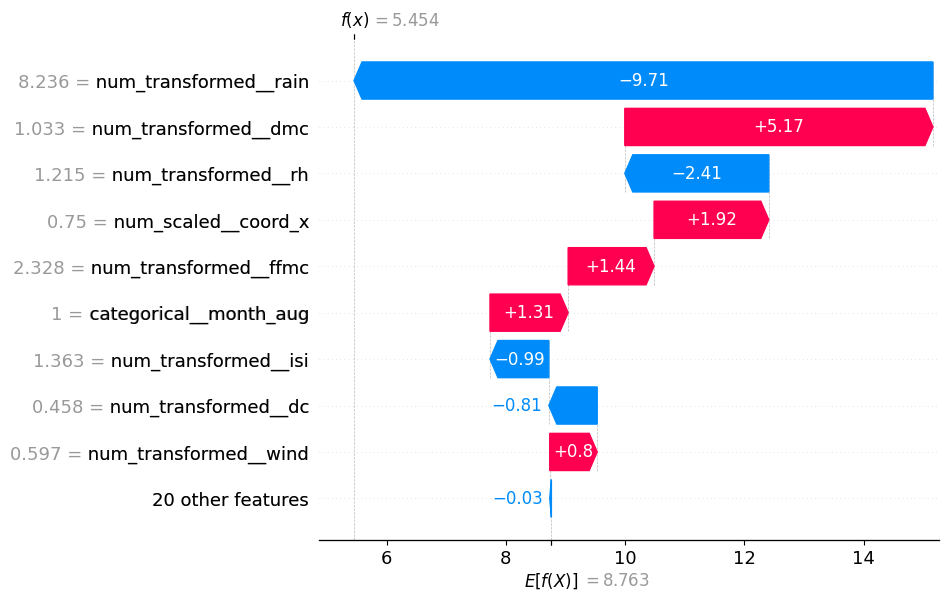

In [388]:
shap.plots.waterfall(shap_values[1])

In [ ]:
shap.plots.beeswarm(shap_values)

In beeswarm plot, features with a wider spread have higher importance. If a feature's spread is narrow, then it does not have a significant impact on the model's predictions. Besides, this diagram sorts the fetures based on their importance. So, the features on bottom might be good candicates to be removed in sake of redusing the feature extraction cost or in some cases improving overal performance of the model. We can remove each, one by one and re-evaluate the model. 

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.